# Рынок заведений общественного питания Москвы

Цель проекта: поиск наиболее перспективных параметров заведения общественного питания в Москве для успешного длительного существования предприятия. Особенность заведения - обслуживание клиентов роботами. 

Задачи: проанализировать рынок ресторанов и кафе на основе открытых данных, подготовить список рекомендаций инвесторам о виде заведения, количестве посадочных мест, а также районе расположения, проанализировать возможное развитие сети, подготовить презентацию.

## Изучение и подготовка данных

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 
import re
import requests
from io import BytesIO

server_path = '/datasets/rest_data.csv'

filename = 'rest_data.csv'

try: 
    rest_data = pd.read_csv(server_path, sep=',')
except: 
    rest_data = pd.read_csv(filename, sep=',') 

In [2]:
spreadsheet_id = '1Twj69JiHbL9Kl-sNCS6loXAFm-e8D6Ec_fOuH4Moa-c'
url =  'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(url)
districts = pd.read_csv(BytesIO(r.content))

In [3]:
rest_data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [4]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Пропусков нет, типы данных соответствуют. В столбце с объектами общественного питания наблюдаются наименования, написанные в верхнем регистре, некоторые их которых гипотетически могут препятствовать поиску сетевых заведений, а также продублированные наименования с разными типами заведений. Необходимо привезти названия к единому образцу и избавиться от кавычек. 

In [5]:
len(rest_data['object_name'].unique())

10393

In [6]:
rest_data['object_name'] = rest_data['object_name'].str.replace('«','')
rest_data['object_name'] = rest_data['object_name'].str.replace('»','')

In [7]:
rest_data['object_name'] = rest_data['object_name'].str.lower()

In [8]:
len(rest_data['object_name'].unique())

9840

Удаление типов мест в названиях заведение может привезти к искажению самих наименований, поскольку в большинстве заведение "кафе", "бар", "кальянная" и проч. являются частью названия. Оставим эти данные как есть. 

***Вывод***

Данные загружены и готовы к анализу. Пропуском и дубликатов нет, типы данных соответствуют содержанию столбцов. Данные с названиями заведений оптимизированы: удалены кавычки и приведены к нижнему регистру. 

## Анализ данных

In [9]:
sns.set_style('whitegrid')

In [10]:
sns.set_palette(sns.color_palette('viridis', 20))

Сперва посмотрим на соотношение видов объектов питания. 

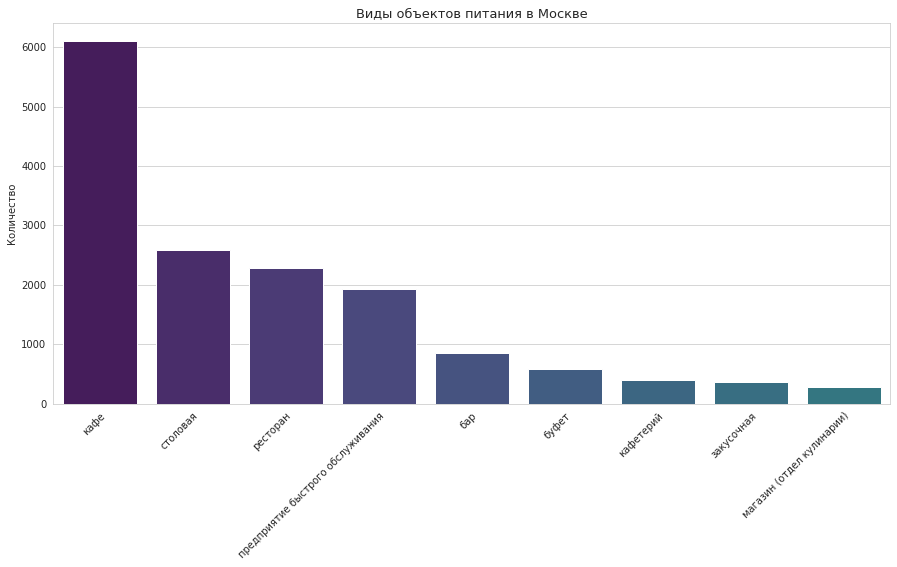

In [11]:
rest_type = rest_data.groupby('object_type')[['id']].count().sort_values(by='id', ascending=False)
plt.figure(figsize = (15, 7))
ax = sns.barplot(x=rest_type.index, y='id', data=rest_type)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('Виды объектов питания в Москве', fontsize=13)
plt.xlabel('')
plt.ylabel('Количество', fontsize=10)
plt.show()

Среди всех типов объектов в Москве больше всего кафе - чуть больше 6 тысяч заведений. Следующие за ним типы - столовая (2,6 тысячи объектов), ресторан (2,3 тысячи) и предприятие быстрого обслуживания (1,9 тысяч). Меньше всего в городе кулинарных магазинов, закусочных и кафетериев. 

Каждый объект обладает своей спецификой. В то время как для ресторанов характерны ценник выше среднего, авторская кухня и определенный запрос аудитории, столовые расчитаны на большой поток клиентов, преимущественно связанных с локацией заведения (школа, университет, предприятие), бары предлагают специфический вид проведения досуга, закусочные и пбо в большинстве случаев не нацелены на создание уюта, что мешает клиентам рассматривать их в качестве места, куда хочется возвращаться, кафе представляет собой больший простор для формирования концепции и лояльной аудитории. Во-первых, кафе доступный и удобный тип заведения для большинства клиентов, во-вторых, нет особых ограничений для бизнеса с точки зрения выбора локации, кухни, размера, интерьера. 

Проверим, сколько в Москве сетевых и несетевых заведений и для какого типа объектов характерно сетевое распространение. 

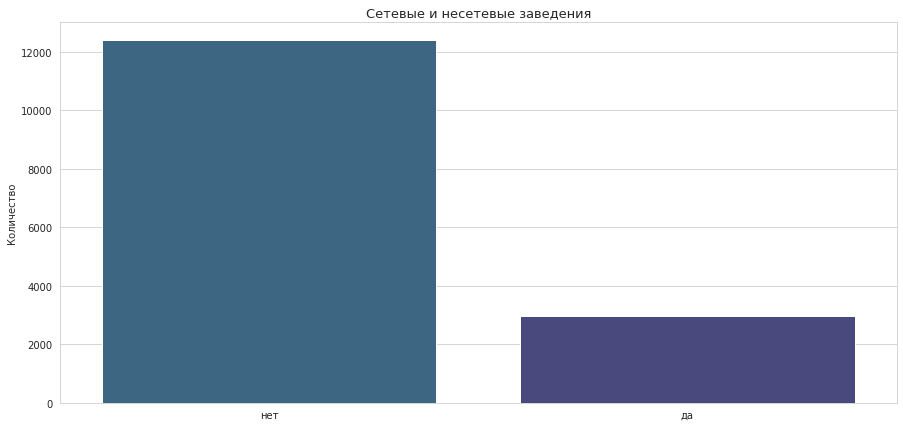

In [12]:
chain_type = rest_data.groupby('chain')[['id']].count().sort_values(by='id', ascending=False)
plt.figure(figsize = (15, 7))
ax = sns.barplot(x=chain_type.index, y='id', data=chain_type, palette=['C6','C3'])
plt.title('Сетевые и несетевые заведения', fontsize=13)
plt.xlabel('')
plt.ylabel('Количество', fontsize=10)
plt.show()

Несетевых заведений общественного питания в Москве превалирующее большинство: 12,2 тысяч единиц против 3 тысяч сетевых точек - более чем в 4 раза. 

Сегодня культура питания в России, особенно в Москве, развивается очень активно. Поход в кафе, ресторан, бар представляет собой не физиологическую необходимость, а способ проведения досуга, поиск новых впечатлений и вкусов. Исходя из этого, мы можем наблюдать рост числа авторских заведений, рассчитанных на узкую, но лояльную аудиторию. 

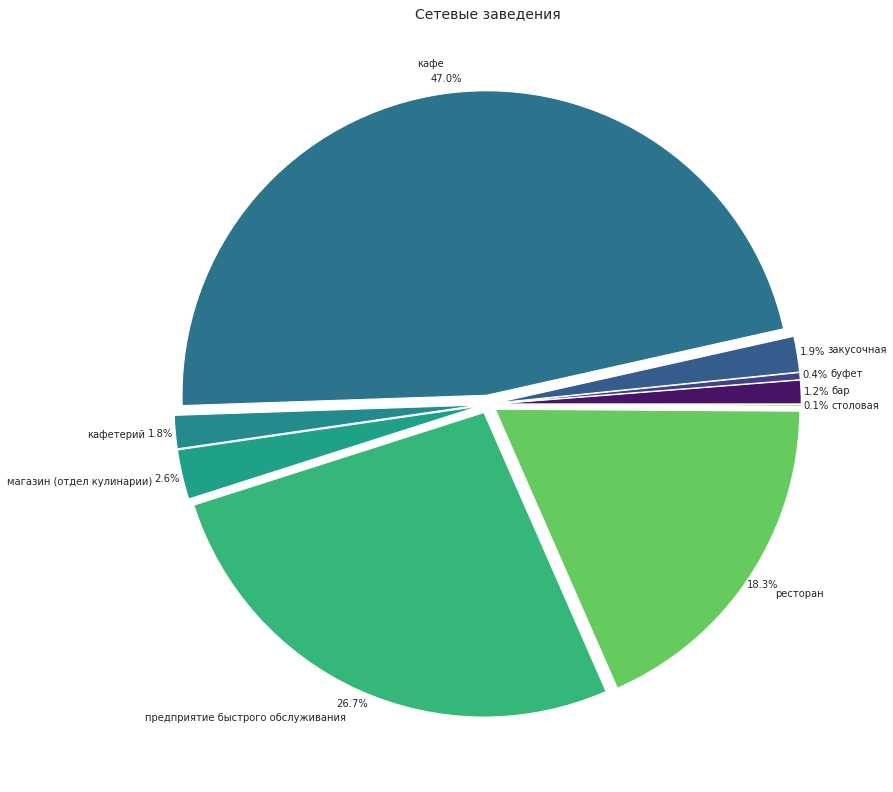

In [13]:
chain_object = rest_data.query('chain == "да"').groupby('object_type')[['id']].count()
plt.figure(figsize = (14, 14))
plt.pie(chain_object['id'], labels=chain_object.index, colors=[
    'C0', 'C3', 'C5', 'C7', 'C9', 'C11', 'C13', 'C15', 'C17'], autopct='%.1f%%', explode=[0.03]*9, pctdistance=1.05)
plt.title('Сетевые заведения', fontsize=14)
plt.show()

Наиболее распространенный тип сетевого объекта - кафе: 47% от всех сетевых заведений. Заметно, что среди сетей доля предприятий быстрого обслуживания больше, чем ресторанов: 26,7% точек фастфуда против 18,3% сетевых ресторанов. Для магазина (отдела кульнарии) свойственно сетевое распространение, но доля среди всех типов объектов его мала. Для закусочных и кафетерий характерен ограниченный ассортимент блюд несложного приготовления: первые локализуются по большей степени в спальных районах, вторые - при продовольственных и крупных непродовльственных магазинах. Буфеты и столовые, обычно со сложной системой собственности, обслуживают рабочих, служащих, студентов и учащихся при специализированном предприятии. 




Следующий шаг: проанализируем параметры сетевых заведений с точки резния количества посадочных мест. Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

In [14]:
chain_object_name = rest_data.query('chain == "да"') 
chain_object_name.head()

,id,object_name,chain,object_type,address,number
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
6,148815,брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10
13,22579,алло пицца,да,кафе,"город Москва, улица Авиаторов, дом 14",32
16,144107,суши wok,да,предприятие быстрого обслуживания,"город Москва, Азовская улица, дом 3",7
18,58565,тануки,да,ресторан,"город Москва, Большая Академическая улица, дом 65",160


Вероятно, некоторые сетевые заведения повторяются в списке, поскольку в некоторых наименованиях присутствую типы объектов, как например, "kfc", "ростикс kfc", "ресторан kfc". Удалим типы объектов по возможности. 

In [15]:
chain_object_name = chain_object_name.reset_index()
chain_object_name.shape

(2968, 7)

In [16]:
chain_object_name['object_name'].unique()

array(['пиццетория', 'брусника', 'алло пицца', 'суши wok', 'тануки',
       "домино'с пицца", 'готика', 'му-му', 'хлеб насущный', 'tajj mahal',
       'данкин донатс', 'вареничная №1', 'шоколадница', 'теремок',
       'хинкальная', 'шантимель', 'хинкальная city', 'кружка', 'суши вок',
       'примавера', 'виктория', 'пиццерия академия', 'чебуречная ссср',
       'макдоналдс', 'grand cru', 'чайхона №1', 'панчо пицца', 'kfc',
       'сабвей', 'ресторан якитория', 'советские времена',
       'кафе андерсон', 'кафе subway', 'ресторан макдоналдс', 'суши сет',
       'шоколад', 'тирольские пироги', 'гамбринус', 'пицца фабрика',
       'subway', 'кафе якитория', 'кафе тануки', 'сити пицца',
       'кофе хаус',
       'кулинарная лавка братьев караваевых братья караваевы', 'прайм',
       'пицца экспресс', 'шоколадница кофе хаус', 'николай', 'якитория',
       'магнолия', 'кофе с собой', 'джаганнат', 'волконский', 'moskalyan',
       'гино-но-таки', 'тратория semplice', 'ньокки', 'хижина',
   

In [17]:
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('кафе ','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('ресторан ','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('пиццерия ','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('кофейня ','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('предприятие быстрого обслуживания ','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('быстрого питания ','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('пбо ','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('закусочная ','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('кондитерская ','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('кондитерская-пекарня ','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('ростикс ','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('кальянная ','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('бар ','', regex=True)

In [18]:
len(chain_object_name['object_name'].unique())

427

Названий сетевых заведений стало меньше на 127 штук. 

Однако еще много заведений, в которых присутсвует топонимы (вроде "kfc волгоградский" или "мята lounge автозаводская"), а также слитно написанные название (например, "ресторанмакдоналдс"). Чтобы еще несколько сократить список, методом перебора наиболее распространеннных названий заведений и типов объектов, не найденных ранее, с помощью кода: 

queries = np.asarray(chain_object_name['object_name'])

for query in queries:

if 'пример' in query: 

print(query)
        
добавим еще несколько строк.

In [19]:
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('детское ','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('детский клуб ','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('домашнее ','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('кальян-','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('семейное и ','', regex=True)

In [20]:
queries = np.asarray(chain_object_name['object_name'])
for query in queries:
    if ',' in query: 
        print(query)

кофе хаус,экспресс
кофемания, бармалини
starbucks, старбакс кофе
хачапури, одесса -мама
суши тун, хруст pizza, кофе тун
домино'с пицца domino,s pizza


In [21]:
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('семейное ','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('лаундж-','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('точка продажи ','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace(' инвест','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('-инвест','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace(' пекарня','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('магазин ','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('магазин-кулинария','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('сеть магазинов ','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('мороженного ','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('готовой еды ','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace(' покрышкина','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace(' волгоградский','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace(' автозаводская','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace(' октябрьская','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace(' шаболовка','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('москва - ','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('сабвей ','', regex=True)

In [22]:
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('сабвей','subway', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace(', старбакс кофе','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('старбакс ','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace(' старбакс','', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('starbucks coffee','starbucks', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('starbucks кофе','starbucks', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('ресторанмакдоналдс','макдоналдс', regex=True)
chain_object_name['object_name'] = chain_object_name['object_name'].str.replace('ресторанвьеткафе','вьет-кафе', regex=True)

In [23]:
len(chain_object_name['object_name'].unique())

396

У нас осталось 396 названий сетевых заведений. К единому образцу приведены не все, поскольку в самих данных есть ошибки с точки зрения заполнения, но уже значительно меньше некачественных значений. 

In [24]:
chain_object_name_new = chain_object_name.groupby('object_name').agg(
    {'id':'nunique', 'number':'mean'}).sort_values(by='id', ascending=False)
chain_object_name_new.head(10)

,id,number
object_name,,
kfc,187,55.866310
шоколадница,183,57.814208
макдоналдс,173,87.017341
бургер кинг,151,46.278146
теремок,111,27.144144
домино'с пицца,98,18.173469
крошка картошка,95,21.368421
милти,80,1.200000
суши wok,76,6.763158


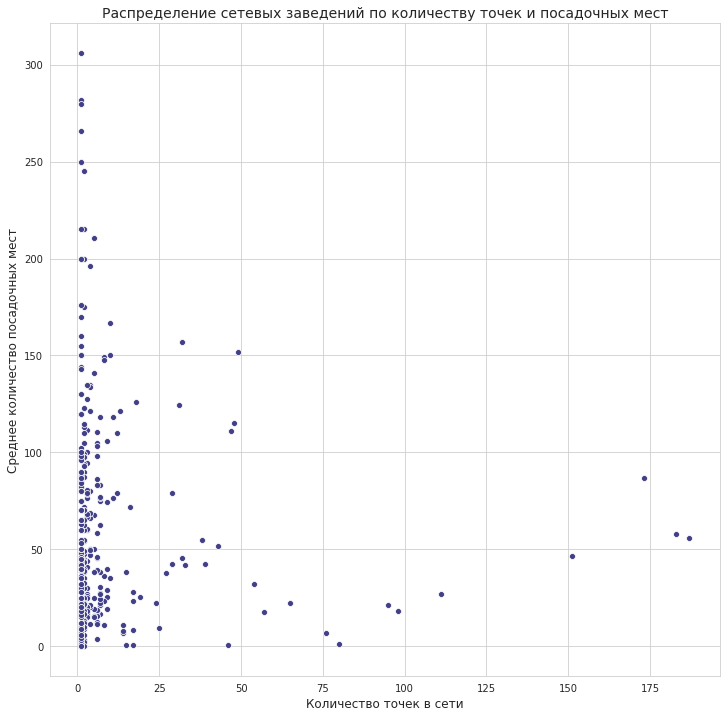

In [25]:
plt.figure(figsize = (12, 12))
sns.scatterplot(data=chain_object_name_new, x='id', y='number', color=['C3'])
plt.title('Распределение сетевых заведений по количеству точек и посадочных мест', fontsize=14)
plt.xlabel('Количество точек в сети', fontsize=12)
plt.ylabel('Среднее количество посадочных мест', fontsize=12)
plt.show()

Сетки с большим количеством (от 150) точек на карте в среднем располагают 50-80 посадочными местами - это такие гиганты как kfc, бургер кинг, макдоналдс и шоколадница. В точках сетей поменьше (от 50 до 125 заведений) посадочных мест в среднем тоже меньше - от 1 до 30 мест. Это обычно средние по размеру пиццерии, сушишопы и фаст-фуд. 

В сетях, количество точек общепита в которых насчитывает от 10 до 50, могут встречаться как небольшие заведения с количеством посадочных мест от 0 до 50, так и крупные точки с числом мест больше 150 и их количество примерно одинаково. 

В совсем мелких сетях (1-3 заведения по городу) налюдается следующая картина: наибольшая концентрация объектов с количеством посадочных мест до 50. Затем чуть-чуть меньше объектов с посадкой на 100 человек. Выше концентрация спадает, но наблюдаются объекты с количеством посадочных от 150 до 305. 

Таким образом, сети, где число заведений небольшое, чаще имеют большее количество посадочных мест, чем крупные франшизы. 

Для каждого вида объекта общественного питания посчитаем среднее количество посадочных мест.

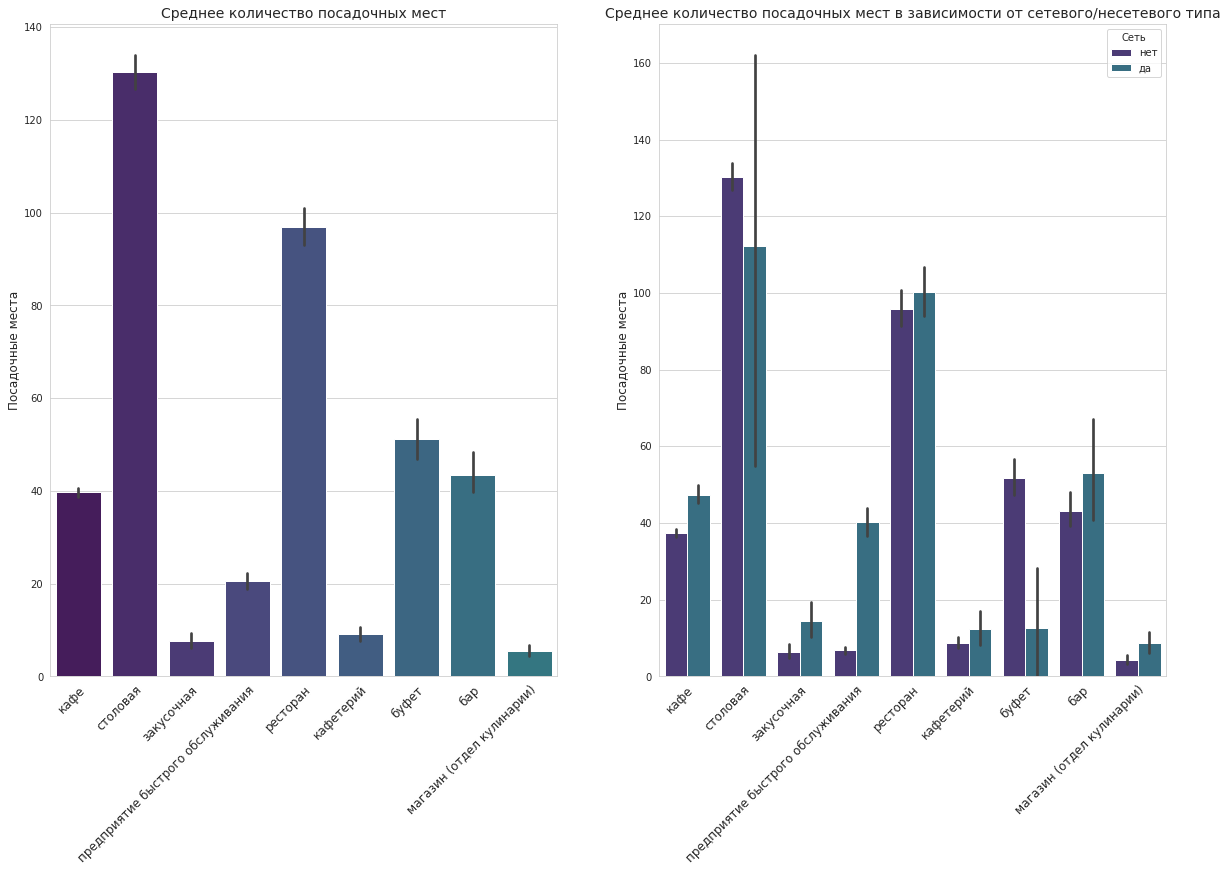

In [26]:
fig, ax=plt.subplots(1,2, figsize=(20, 12))

sns.barplot(data=rest_data, x='object_type', y='number', ax=ax[0])
sns.barplot(data=rest_data, x='object_type', y='number', hue='chain', ax=ax[1], palette=['C2', 'C7'])

ax[0].set_title('Среднее количество посадочных мест', fontsize=14)
ax[1].set_title('Среднее количество посадочных мест в зависимости от сетевого/несетевого типа', fontsize=14)

locs, labels = plt.xticks()
ax[0].set_xticklabels(labels, rotation=45, rotation_mode='anchor', ha='right', fontsize=12)
ax[1].set_xticklabels(labels, rotation=45, rotation_mode='anchor', ha='right', fontsize=12)

ax[0].set_xlabel('')
ax[1].set_xlabel('')

ax[0].set_ylabel('Посадочные места', fontsize=12)
ax[1].set_ylabel('Посадочные места', fontsize=12)

plt.legend(title='Сеть')
plt.show()

Для столовой наиболее характерно большое количество посадочных мест - в среднем 130. В разрезе по принадлежности к сети, среднее у отметки в 110, однако, разброс значений сильнее. Рестораны, как сетевые, так и несетевые в среднем имеют 90-100 посадочных мест. Сетевые предприятия быстрого обслуживания имеют в среднем 40 посадочных мест, тогда как несетевые 20. Сетевые кафе также несколько больше несетевых в размерах.   

Кафетерии, закусочные, магазины кулинарии зачастую совсем не имеют посадки и работают на вынос. Для баров, кафе свойственно создание уникальной атмосферы с ограниченным количеством посадочных мест. Столовые расчитаны на единовременное обслуживание большого числа клиентов. Рестораны, в свою очередь, одной из опций предлагают проведение мероприятий, банкетов, конференций на большое число гостей. 

Теперь необходимо из столбца с адресом выделить улицы, на которых расположены заведения. 

In [27]:
rest_data['street'] = rest_data['address']

In [28]:
words = ['улица','ул','переулок','шоссе','проспект','площадь',
         'проезд','аллея','бульвар','набережная','тупик','линия','квартал','микрорайон','километр','территория','просек']

str_pat = r"(([A-zА-я0-9\sёЁ -]+)?(?:{})([ A-zА-я0-9]+)?)".format("|".join(words))

rest_data['street'] = rest_data['address'].str.extract(str_pat, flags=re.I)
rest_data['street'] = rest_data['street'].str.strip()

In [29]:
rest_data['street'] = rest_data['street'].fillna('Без улицы')

In [30]:
rest_data.head()

,id,object_name,chain,object_type,address,number,street
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,кафе академия,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,кафе вишневая метель,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица


In [31]:
rest_data.query('street == "Без улицы"').tail()

,id,object_name,chain,object_type,address,number,street
14981,216909,кафе,нет,буфет,"город Москва, поселение Десеновское, деревня В...",10,Без улицы
14997,216942,шашлычный дворик,нет,кафе,"город Москва, поселение Десеновское, деревня В...",15,Без улицы
14998,216926,кафе сахли,нет,закусочная,"город Москва, поселение Десеновское, деревня В...",10,Без улицы
15015,208239,газпромнефть,нет,кафе,"поселение ""Мосрентген"", деревня Дудкино, владе...",20,Без улицы
15184,220587,пицца паоло,да,кафетерий,"город Москва, город Зеленоград, корпус 1627",0,Без улицы


In [32]:
queries = np.asarray(rest_data['address'])
for query in queries:
    if 'Школьная' in query:
        print(query)

город Москва, Школьная улица, дом 13
город Москва, Школьная улица, дом 21
город Москва, поселение Роговское, посёлок Рогово, Школьная улица, дом 5А
город Москва, город Троицк, Школьная улица, дом 10
город Москва, город Троицк, Школьная улица, дом 10А
Школьная улица, дом 48, строение 1
город Москва, поселение Щаповское, посёлок Курилово, Школьная улица, дом 3
город Москва, поселение Первомайское, деревня Горчаково, Школьная улица, дом 1А
город Москва, поселение Первомайское, деревня Горчаково, Школьная улица, дом 1А


В нашем датасете много населенных пунктов, которые находятся в юрисдикции Москвы как субъекта РФ, но имеют собственную систему топонимов, из-за чего некоторые улицы самой Москвы могут пересекаться в названиях с улицами поселений и мелких городов, таких как Троицк или Зеленоград. Например, Школьная улица в Москве расположена в Таганском районе, но улица с таким же названием есть в Троицке и еще нескольких поселениях за пределами МКАД и ЦКАД. 

In [33]:
queries = np.asarray(rest_data['address'])
for query in queries:
    if 'Калужское шоссе' in query:
        print(query)

город Москва, поселение Сосенское, Калужское шоссе, 22-й километр, дом 10
город Москва, поселение Сосенское, Калужское шоссе, 22-й километр, дом 10
город Москва, поселение Сосенское, Калужское шоссе, 22-й километр, дом 10
город Москва, поселение Сосенское, Калужское шоссе, 22-й километр, дом 10
город Москва, поселение Сосенское, Калужское шоссе, 22-й километр, дом 10
город Москва, поселение Сосенское, Калужское шоссе, 22-й километр, дом 10
город Москва, поселение Сосенское, Калужское шоссе, 22-й километр, дом 10
город Москва, поселение Сосенское, Калужское шоссе, 22-й километр, дом 10
город Москва, поселение Сосенское, Калужское шоссе, 22-й километр, дом 10
город Москва, поселение Сосенское, Калужское шоссе, 22-й километр, дом 10
город Москва, поселение Сосенское, Калужское шоссе, 22-й километр, дом 10
город Москва, поселение Сосенское, Калужское шоссе, 22-й километр, дом 10
город Москва, поселение Сосенское, Калужское шоссе, 22-й километр, дом 10
город Москва, поселение Сосенское, Кал

Или, например, есть очень длинные улицы как Калужское шоссе, которые идут сквозь несколько московских поселений. Предположим, что аудитория будущего заведения со специфическим роботизированным обслуживанием все-таки локализуется в центральных районах Москвы, поэтому, во-первых, чтобы избежать неправильной группировки по улицам, во-вторых, ограничить локацию заведения МКАДом, удалим из датасета строки, в адресе которых указаны мелкие поселения и города Москвы.

In [34]:
rest_data = rest_data[~rest_data['address'].str.contains('поселение')]
rest_data = rest_data[~rest_data['address'].str.contains('посёлок')]
rest_data = rest_data[~rest_data['address'].str.contains('город Зеленоград')]
rest_data = rest_data[~rest_data['address'].str.contains('город Троицк')]
rest_data = rest_data[~rest_data['address'].str.contains('город Щербинка')]
rest_data = rest_data[~rest_data['address'].str.contains('город Московский')]
rest_data = rest_data[~rest_data['address'].str.contains('деревня')]

Теперь наша задача найти топ-10 улиц с наибольшим количеством заведений и с помощью внешних данных определить район города, в котором они расположены. А также найти улицы с всего одним объектом общественного питания и выяснить район.

In [35]:
districts.head()

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


In [36]:
districts = districts.drop(['areaid', 'okrug'], axis=1)

In [37]:
districts.columns = ['street', 'area']
districts['street'] = districts['street'].str.strip()
districts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 2 columns):
street    4398 non-null object
area      4398 non-null object
dtypes: object(2)
memory usage: 68.8+ KB


In [38]:
top_streets = rest_data.groupby('street')[['id']].nunique().reset_index().sort_values(by='id', ascending=False)
top10_streets = top_streets.head(10)
top10_streets

,street,id
1379,проспект Мира,204
996,Профсоюзная улица,183
683,Ленинградский проспект,173
981,Пресненская набережная,167
406,Варшавское шоссе,162
686,Ленинский проспект,148
1376,проспект Вернадского,132
674,Кутузовский проспект,114
600,Каширское шоссе,112
605,Кировоградская улица,110


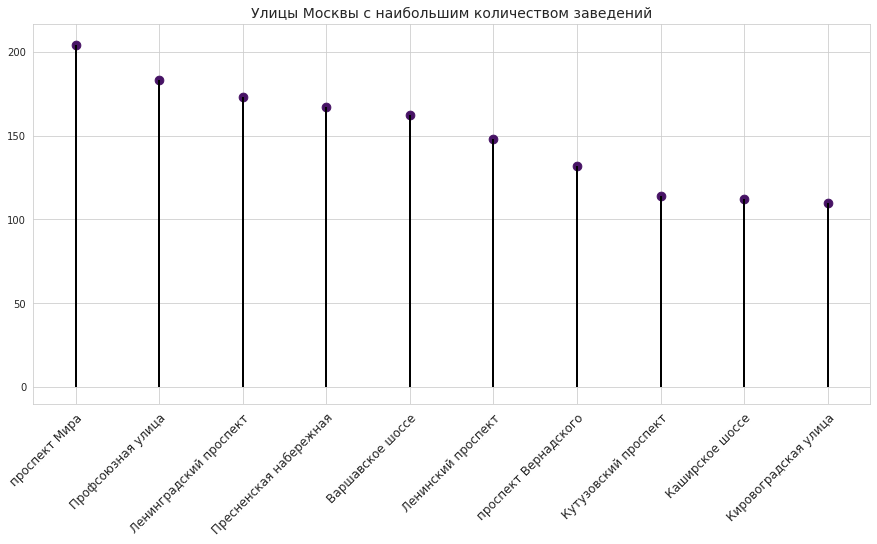

In [39]:
fig, ax = plt.subplots(figsize = (15, 7))
ax.vlines(data=top10_streets, x='street', ymin=0, ymax=top10_streets.id, linewidth=2)
ax.scatter(x='street', y='id', s=75, data=top10_streets)

plt.xticks(rotation=45, rotation_mode='anchor', ha='right', fontsize=12)
plt.title('Улицы Москвы с наибольшим количеством заведений', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.show()

Так, улицами Москвы с наибольши количеством заведений общепита являются проспект Мира, Профсоюзная улица, Ленинградский проспект, Пресненская набережная, Варшавское шоссе, Ленинский проспект, проспект Вернадского, Кутузовский проспект, Каширское шоссе, Кировоградская улица. На проспекте Мира находится 204 заведения. 	

In [40]:
top10_with_districts = top10_streets.merge(districts, on='street', how='left')
top10 = top10_with_districts.pivot_table(index=['street', 'area'])
top10

id
street                 area                                
Варшавское шоссе       Донской район                    162
                       Нагорный район                   162
                       Район Нагатино-Садовники         162
                       Район Северное Бутово            162
                       Район Чертаново Северное         162
                       Район Чертаново Центральное      162
                       Район Чертаново Южное            162
                       Район Южное Бутово               162
Каширское шоссе        Район Москворечье-Сабурово       112
                       Район Нагатино-Садовники         112
                       Район Орехово-Борисово Северное  112
                       Район Орехово-Борисово Южное     112
Кировоградская улица   Район Чертаново Северное         110
                       Район Чертаново Центральное      110
                       Район Чертаново Южное            110
Кутузовский проспект   Район Дорогомилово               114
                       Район Фили-Давыдково             114
Ленинградский проспект Район Аэропорт                   173
                       Район Беговой                    173
                       Район Сокол                      173
                       Хорошевский район                173
Ленинский проспект     Донской район                    148
                       Ломоносовский район              148
                       Обручевский район                148
                       Район Гагаринский                148
                       Район Проспект Вернадского       148
                       Район Теплый Стан                148
                       Район Тропарево-Никулино         148
                       Район Якиманка                   148
Пресненская набережная Пресненский район                167
Профсоюзная улица      Академический район              183
                       Обручевский район                183
                       Район Коньково                   183
                       Район Теплый Стан                183
                       Район Черемушки                  183
                       Район Ясенево                    183
проспект Вернадского   Ломоносовский район              132
                       Район Гагаринский                132
                       Район Проспект Вернадского       132
                       Район Раменки                    132
                       Район Тропарево-Никулино         132
проспект Мира          Алексеевский район               204
                       Мещанский район                  204
                       Останкинский район               204
                       Район Марьина роща               204
                       Район Ростокино                  204
                       Район Свиблово                   204
                       Ярославский Район                204

In [41]:
top_districts = top10.groupby(['area', 'street']).agg({'id':'count'}).drop(['id'], axis=1)
top_districts

Empty DataFrame
Columns: []
Index: [(Академический район, Профсоюзная улица), (Алексеевский район, проспект Мира), (Донской район, Варшавское шоссе), (Донской район, Ленинский проспект), (Ломоносовский район, Ленинский проспект), (Ломоносовский район, проспект Вернадского), (Мещанский район, проспект Мира), (Нагорный район, Варшавское шоссе), (Обручевский район, Ленинский проспект), (Обручевский район, Профсоюзная улица), (Останкинский район, проспект Мира), (Пресненский район, Пресненская набережная), (Район Аэропорт, Ленинградский проспект), (Район Беговой, Ленинградский проспект), (Район Гагаринский, Ленинский проспект), (Район Гагаринский, проспект Вернадского), (Район Дорогомилово, Кутузовский проспект), (Район Коньково, Профсоюзная улица), (Район Марьина роща, проспект Мира), (Район Москворечье-Сабурово, Каширское шоссе), (Район Нагатино-Садовники, Варшавское шоссе), (Район Нагатино-Садовники, Каширское шоссе), (Район Орехово-Борисово Северное, Каширское шоссе), (Район Орехово-Борисово Южное, Каширское шоссе), (Район Проспект Вернадского, Ленинский проспект), (Район Проспект Вернадского, проспект Вернадского), (Район Раменки, проспект Вернадского), (Район Ростокино, проспект Мира), (Район Свиблово, проспект Мира), (Район Северное Бутово, Варшавское шоссе), (Район Сокол, Ленинградский проспект), (Район Теплый Стан, Ленинский проспект), (Район Теплый Стан, Профсоюзная улица), (Район Тропарево-Никулино, Ленинский проспект), (Район Тропарево-Никулино, проспект Вернадского), (Район Фили-Давыдково, Кутузовский проспект), (Район Черемушки, Профсоюзная улица), (Район Чертаново Северное, Варшавское шоссе), (Район Чертаново Северное, Кировоградская улица), (Район Чертаново Центральное, Варшавское шоссе), (Район Чертаново Центральное, Кировоградская улица), (Район Чертаново Южное, Варшавское шоссе), (Район Чертаново Южное, Кировоградская улица), (Район Южное Бутово, Варшавское шоссе), (Район Якиманка, Ленинский проспект), (Район Ясенево, Профсоюзная улица), (Хорошевский район, Ленинградский проспект), (Ярославский Район, проспект Мира)]

Топ-10 улиц по количеству предприятий общественного питания находится в следующих районах: Академический, Алексеевский, Донской, Ломоносовский, Мещанский, Нагорный, Обручевский, Останкинский, Пресненский, Аэропорт, Беговой, Гагаринский, Дорогомилово, Коньково, Марьина роща, Москворечье-Сабурово, Нагатино-Садовники, Орехово-Борисово Северное, Орехово-Борисово Южное, Проспект Вернадского, Раменки, Ростокино, Свиблово, Северное Бутово, Южное Бутово, Сокол, Теплый Стан, Тропарево-Никулино, Фили-Давыдково, Черемушки, Чертаново Северное, Чертаново Центральное, Чертаново Южное, Якиманка, Ясенево, Хорошевский, Ярославский.

Большинство улиц проходят сквозь несколько районов. Так, 204 заведения на проспекте Мира распределены по территории семи районов. Наибольшее число мест, сконцентрированных в одном районе, находится на Пресненской набережной в Пресненском районе. Также высокая концентрация на Кутузовском проспекте, которых пересекает два района - Дорогомилово и Фили-Давыдково.

Такое количество заведений может быть связано с длиной улиц, которые являются ключевыми транспортными магистралями и пересекают множество станций метро, деловых центров, мест скопления людей с разными целями. 

Теперь посмотрим на улицы, где всего один объект общественного питания.

In [42]:
one_object = top_streets.query('id == 1')
one_object.head(10)

,street,id
221,7-й Ростовский переулок,1
170,3-я Новоостанкинская улица,1
144,2-я улица Бухвостова,1
233,80-й километр Московской Кольцевой Автодороги,1
162,3-й Стрелецкий проезд,1
163,3-й Угрешский проезд,1
1539,улица Знаменские Садки,1
225,7-я улица Лазенки,1
224,7-я Северная линия,1
1552,улица Каманина,1


Судя по карте, эти улицы либо совсем короткие и находятся в спальных районах, либо являются частью крупных транспортных развязок, не приспособленных для остановки и перекуса. 

In [43]:
one_object.shape[0]

538

In [44]:
one_object_with_district = one_object.merge(districts, on='street', how='left')
one_object_with_district = one_object_with_district.dropna()
one_object_with_district.head()

,street,id,area
0,7-й Ростовский переулок,1,Район Хамовники
1,3-я Новоостанкинская улица,1,Останкинский район
2,2-я улица Бухвостова,1,Район Преображенское
4,3-й Стрелецкий проезд,1,Район Марьина роща
5,3-й Угрешский проезд,1,Район Печатники


In [45]:
districts_with_streets = one_object_with_district.groupby('area', as_index=False)[['street']].count()
districts_with_streets.head()

,area,street
0,Алексеевский район,7
1,Алтуфьевский район,1
2,Бабушкинский район,5
3,Басманный район,25
4,Бескудниковский Район,2


In [46]:
districts_with_streets['area'].unique()

array(['Алексеевский район', 'Алтуфьевский район', 'Бабушкинский район',
       'Басманный район', 'Бескудниковский Район', 'Бутырский район',
       'Войковский Район', 'Головинский район', 'Даниловский район',
       'Дмитровский район', 'Донской район', 'Красносельский район',
       'Лосиноостровский район', 'Мещанский район', 'Можайский Район',
       'Молжаниновский район', 'Нагорный район', 'Нижегородский район',
       'Обручевский район', 'Останкинский район', 'Пресненский район',
       'Район Арбат', 'Район Аэропорт', 'Район Беговой',
       'Район Бирюлево Восточное', 'Район Богородское', 'Район Внуково',
       'Район Восточное Измайлово', 'Район Восточный',
       'Район Выхино-Жулебино', 'Район Гагаринский', 'Район Гольяново',
       'Район Дорогомилово', 'Район Замоскворечье',
       'Район Западное Дегунино', 'Район Зюзино', 'Район Ивановское',
       'Район Измайлово', 'Район Коньково', 'Район Коптево',
       'Район Косино-Ухтомский', 'Район Котловка', 'Район Крюково

На 538 улицах Москвы всего по одному заведению общепита. Эти улицы расположены в 101 районе города, названия которых в списке выше.

Посмотрим на распределение количества посадочных мест с большим количеством объектов общественного питания. 

In [47]:
top10_streets = top10_streets.set_index(['street'])

In [48]:
number_street = rest_data.query('street in @top10_streets.index')

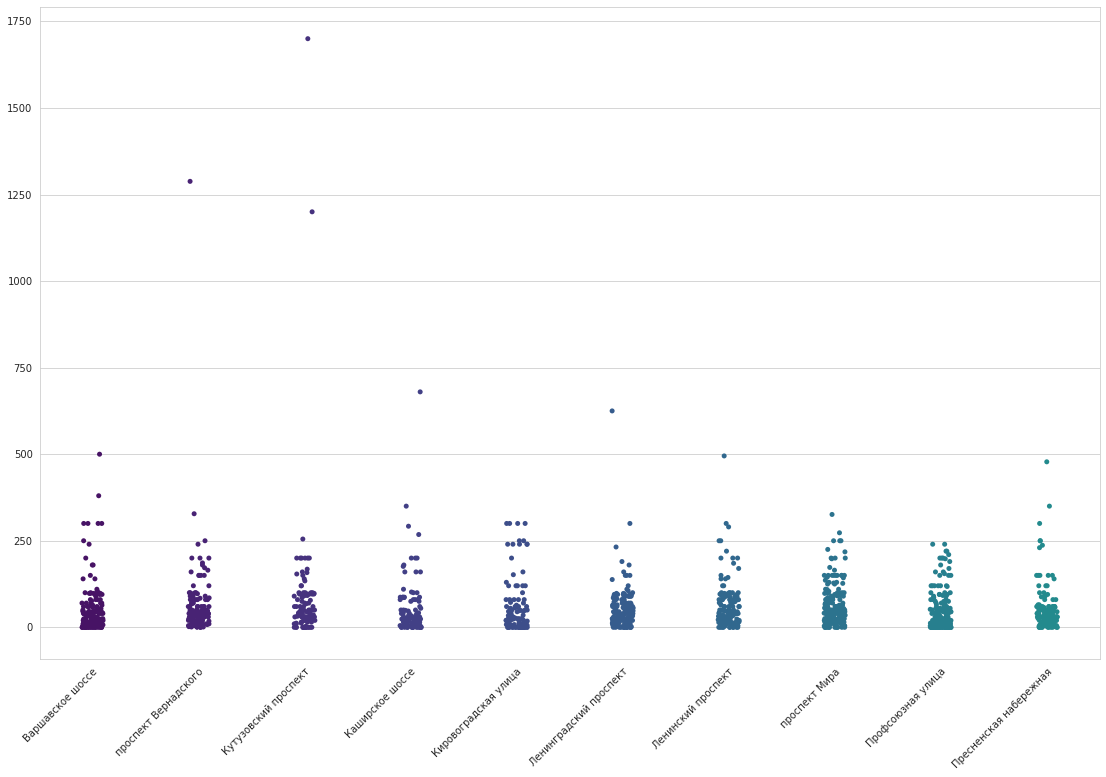

In [49]:
fig, ax = plt.subplots(figsize=(19, 12))
sns.stripplot(data=number_street, x='street', y='number', ax=ax)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('', fontsize=13)
plt.xlabel('')
plt.ylabel('', fontsize=10)
plt.show()

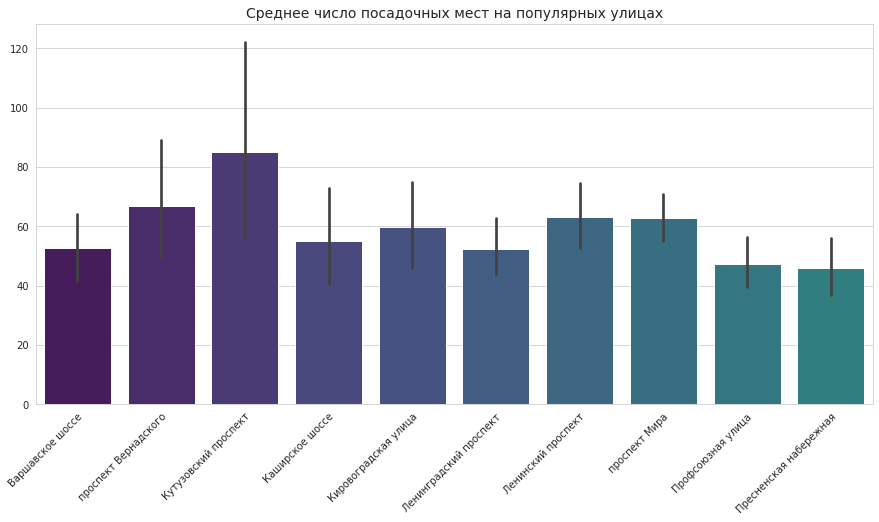

In [50]:
plt.figure(figsize = (15, 7))
ax = sns.barplot(data=number_street, x='street', y='number')
plt.title('Среднее число посадочных мест на популярных улицах', fontsize=14)
plt.xlabel('')
plt.ylabel('', fontsize=10)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.show()

In [51]:
number_street[number_street['number'] > 500]

,id,object_name,chain,object_type,address,number,street
4110,29320,столовая,нет,столовая,"город Москва, Каширское шоссе, дом 31",680,Каширское шоссе
4480,27024,рум сервис,нет,ресторан,"город Москва, Кутузовский проспект, дом 2/1, с...",1200,Кутузовский проспект
7104,27033,банкетный,нет,ресторан,"город Москва, Ленинградский проспект, дом 31А,...",625,Ленинградский проспект
9064,19719,комбинат питания управление академсервис,нет,столовая,"город Москва, проспект Вернадского, дом 84, ст...",1288,проспект Вернадского
12723,199696,arena by soho family,нет,бар,"город Москва, Кутузовский проспект, дом 36, ст...",1700,Кутузовский проспект


На Варшавском шоссе, Каширском шоссе и Ленинградском проспекте среднее количество посадочных мест чуть больше 50. На Кировоградской улице, Ленинском проспекте и проспекте Мира среднее количество посадочных мест в заведении колеблется от 60 до 65. Самая небольшая посадка на Профсоюзной улице и Пресненской набережной - меньше 50 мест. 
Среднее количество посадочных мест на проспекте Вернадского (68) и Кутузовском проспекте (83) обосновано значительными выбросами - на первом наблюдается заведение с 1288 посадочных мест - столовая университета РАНХиГС, а на Кутузовском находится высотка, внутри которой ресторан отеля, а также концертная арена на 1700 мест с баром. 

## Выводы

- Среди всех типов объектов в Москве больше всего *кафе* - чуть больше 6 тысяч заведений. Следующие за ним типы - столовая (2,6 тысячи объектов), ресторан (2,3 тысячи) и предприятие быстрого обслуживания (1,9 тысяч). Меньше всего в городе кулинарных магазинов, закусочных и кафетериев.


- *Несетевых заведений общественного питания в Москве превалирующее большинство:* 12,2 тысяч единиц против 3 тысяч сетевых точек - более чем в 4 раза. Это связано с ростом числа авторских заведений, рассчитанных на узкую, но лояльную аудиторию.


- Наиболее распространенный тип сетевого объекта - кафе: 47% от всех сетевых заведений. Заметно, что среди сетей доля предприятий быстрого обслуживания больше, чем ресторанов: 26,7% точек фастфуда против 18,3% сетевых ресторанов. 


- Сетки с большим количеством (от 150) точек на карте в среднем располагают 50-80 посадочными местами - это такие гиганты как kfc, бургер кинг, макдоналдс и шоколадница. В точках сетей поменьше (от 50 до 125 заведений) посадочных мест в среднем тоже меньше - от 1 до 30 мест. Это обычно средние по размеру пиццерии, сушишопы и фаст-фуд. В сетях, количество точек общепита в которых насчитывает от 10 до 50, могут встречаться как небольшие заведения с количеством посадочных мест от 0 до 50, так и крупные точки с числом мест больше 150 и их количество примерно одинаково. В совсем мелких сетях (1-3 заведения по городу) налюдается следующая картина: наибольшая концентрация объектов с количеством посадочных мест до 50. Затем чуть-чуть меньше объектов с посадкой на 100 человек. Выше концентрация спадает, но наблюдаются объекты с количеством посадочных от 150 до 305. *Сети, где число заведений небольшое, чаще имеют большее количество посадочных мест, чем крупные франшизы.*


- Улицами Москвы с наибольши количеством заведений общепита являются: *проспект Мира, Профсоюзная улица, Ленинградский проспект, Пресненская набережная, Варшавское шоссе, Ленинский проспект, проспект Вернадского, Кутузовский проспект, Каширское шоссе, Кировоградская улица. На проспекте Мира находится 204 заведения.*


- Топ-10 улиц по количеству предприятий общественного питания находится в следующих районах: *Академический, Алексеевский, Донской, Ломоносовский, Мещанский, Нагорный, Обручевский, Останкинский, Пресненский, Аэропорт, Беговой, Гагаринский, Дорогомилово, Коньково, Марьина роща, Москворечье-Сабурово, Нагатино-Садовники, Орехово-Борисово Северное, Орехово-Борисово Южное, Проспект Вернадского, Раменки, Ростокино, Свиблово, Северное Бутово, Южное Бутово, Сокол, Теплый Стан, Тропарево-Никулино, Фили-Давыдково, Черемушки, Чертаново Северное, Чертаново Центральное, Чертаново Южное, Якиманка, Ясенево, Хорошевский, Ярославский.*


- Большинство улиц проходят сквозь несколько районов. Так, 204 заведения на проспекте Мира распределены по территории семи районов. *Наибольшее число мест, сконцентрированных в одном районе находится на Пресненской набережной в Пресненском районе. Также высокая концентрация на Кутузовском проспекте, которых пересекает два района - Дорогомилово и Фили-Давыдково. Такое количество заведений может быть связано с длиной улиц, которые являются ключевыми транспортными магистралями и пересекают множество станций метро, деловых центров, мест скопления людей с разными целями.*


- На 538 улицах Москвы всего по одному заведению общепита. Эти улицы расположены в 101 районе города. Судя по карте, *эти улицы либо совсем короткие и находятся в спальных районах, либо являются частью крупных транспортных развязок, не приспособленных для остановки и перекуса.*


- На Варшавском шоссе, Каширском шоссе и Ленинградском проспекте среднее количество посадочных мест чуть больше 50. На Кировоградской улице, Ленинском проспекте и проспекте Мира среднее количество посадочных мест в заведении колеблется от 60 до 65. Самая небольшая посадка на Профсоюзной улице и Пресненской набережной - меньше 50 мест. Среднее количество посадочных мест на проспекте Вернадского (68) и Кутузовском проспекте (83) обосновано значительными выбросами - на первом наблюдается заведение с 1288 посадочных мест - столовая университета РАНХиГС, а на Кутузовском находится высотка, внутри которой ресторан отеля, а также концертная арена на 1700 мест с баром.

## Рекомендации

Наиболее перспективным сценарием для открытия заведения с роботизированным обслуживанием является, на мой вгляд, несетевое кафе с количеством мест около 50. Кафе, по сравнению с другими типами объектов, представляет собой больший простор для формирования концепции и лояльной аудитории. Во-первых, кафе доступный и удобный тип заведения для большинства клиентов, во-вторых, нет особых ограничений для бизнеса с точки зрения выбора локации, кухни, размера, интерьера.

Район, вероятно, должен быть концентрирован желающими перекусить, поэтому выбор Пресненской набережной кажется адекватным. Плюс деловой центр располагает для открытия заведения с уникальной быстрой системой обслуживания. В случае, если проект окажется успешным его можно развить в других районах большого скопления людей, например, на проспекте Вернадского, где расположено скопление университетов. 

Ссылка на презентацию: https://drive.google.com/file/d/1L_9ZPH-J4sipDvIugoov4Jy0VAMfZs6Z/view?usp=sharing